In [7]:
import torch
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [8]:
class REncoder(torch.nn.Module):
    """
    Encodes inputs of the form (x_i, y_i) into representations, r_i
    """
    def __init__(self, in_dim, out_dim, init_func=torch.nn.init.normal_):
        super(REncoder, self).__init__()
        self.l1_size = 8

        self.l1 = torch.nn.Linear(in_dim, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, out_dim)

        self.a = torch.nn.ReLU() # I thought it should be average though?

        if init_func is not None:
            init_func(self.l1.weight)
            init_func(self.l2.weight)

    def forward(self, inputs):
        return self.l2(self.a(self.l1(inputs)))

class ZEncoder(torch.nn.Module):
    """
    Takes an r representations and produces the mean & stf of the latent
    representation z
    """
    def __init__(self, in_dim, out_dim, init_func=torch.nn.init.normal_):

        super(ZEncoder, self).__init__()
        self.m1_size = out_dim
        self.std1_size = out_dim

        self.m1 = torch.nn.Linear(in_dim, self.m1_size)
        self.std1 = torch.nn.Linear(in_dim, self.std1_size)

        if init_func is not None:
            init_func(self.m1.weight)
            init_func(self.std1.weight)

    def forward(self, inputs):
        softplus = torch.nn.Softplus()
        return self.m1(inputs), softplus(self.std1(inputs))

class Decoder(torch.nn.Module):
    """
    Takes the x_star points, along with a function encoding z, to make
    predictions
    """

    def __init__(self, in_dim, out_dim, init_func=torch.nn.init.normal_):
        super(Decoder, self).__init__()
        self.l1_size = 8
        self.l2_size = 8

        self.l1 = torch.nn.Linear(in_dim, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, out_dim)

        if init_func is not None:
            init_func(self.l1.weight)
            init_func(self.l2.weight)

        self.a = torch.nn.Sigmoid()

    def forward(self, x_pred, z):
        """
        Not sure what is happening
        """
        zs_reshaped = z.unsqueeze(-1).expand(z.shape[0], z.shape[1], x_pred.shape[0]).transpose(1,2)
        xpred_reshaped = x_pred.unsqueeze(0).expand(z.shape[0], x_pred.shape[0], x_pred.shape[1])

        xz = torch.cat([xpred_reshaped, zs_reshaped], dim=2)
        return self.l2(self.a(self.l1(xz))).squeeze(-1).transpose(0,1), 0.005


def log_likelihood(mu, std, target):
    norm = torch.distributions.Normal(mu, std)
    return norm.log_prob(target).sum(dim=0).mean()

def KLD_gaussian(mu_q, std_q, mu_p, std_p):
    """Analytical KLD between 2 Gaussians."""
    qs2 = std_q**2 + 1e-16
    ps2 = std_p**2 + 1e-16

    return (qs2/ps2 + ((mu_q-mu_p)**2)/ps2 + torch.log(ps2/qs2) - 1.0).sum()*0.5

def random_split_context_target(x,y, n_context):
    """Helper function to split randomly into context and target"""
    ind = np.arange(x.shape[0])
    mask = np.random.choice(ind, size=n_context, replace=False)
    return x[mask], y[mask], np.delete(x, mask, axis=0), np.delete(y, mask, axis=0)

def sample_z(mu, std, n):
    """Reparameterisation trick."""
    eps = torch.autograd.Variable(std.data.new(n,z_dim).normal_())
    return mu + std * eps

def data_to_z_params(x, y):
    """Helper to batch together some steps of the process."""
    xy = torch.cat([x,y], dim=1)
    rs = r_encoder(xy)
    r_agg = rs.mean(dim=0) # Average over samples
    return z_encoder(r_agg) # Get mean and variance for q(z|...)

def visualise(x, y, x_star):
    z_mu, z_std = data_to_z_params(x,y)
    zsamples = sample_z(z_mu, z_std, 100)

    mu, _ = decoder(x_star, zsamples)
    for i in range(mu.shape[1]):
        plt.plot(x_star.data.numpy(), mu[:,i].data.numpy(), linewidth=1)
    plt.scatter(x.data.numpy(), y.data.numpy())
    plt.show()


In [9]:
r_dim = 2
z_dim = 2
x_dim = 1
y_dim = 1
n_z_samples = 10

r_encoder = REncoder(x_dim+y_dim, r_dim)
z_encoder = ZEncoder(r_dim, z_dim)
decoder = Decoder(x_dim + z_dim, y_dim)

opt = torch.optim.Adam(list(decoder.parameters())
                      +list(z_encoder.parameters())
                      +list(r_encoder.parameters()), 1e-3)

# generate samples from untrained NP

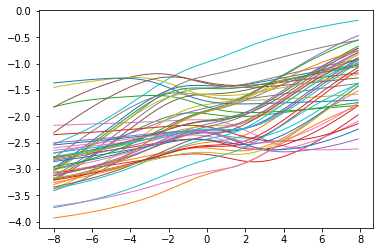

In [10]:
x_grid = torch.from_numpy(np.arange(-8, 8, 0.1).reshape(-1, 1).astype(np.float32))

untrained_zs = torch.from_numpy(np.random.normal(size=(50, z_dim)).astype(np.float32))
mu, _ = decoder(x_grid, untrained_zs)

# generated 50 samples
for i in range(mu.shape[1]):
    plt.plot(x_grid.data.numpy(), mu[:,i].data.numpy(), linewidth=1)

plt.show()

In [11]:
all_x_np = np.arange(-2, 3, 1.0).reshape(-1, 1).astype(np.float32)
all_y_np = np.sin(all_x_np)

In [14]:
x_context, y_context, x_target, y_target = random_split_context_target(
    all_x_np, all_y_np, 4)

In [18]:
y_target

array([[-0.84147096]], dtype=float32)

In [18]:
def train(n_epochs, n_display=3000, return_loss = False):
    losses = []
    for t in range(n_epochs):
        opt.zero_grad()
        
        # data gen
        x_context, y_context, x_target, y_target = random_split_context_target(
            all_x_np, all_y_np, np.random.randint(1, 4))
        
        # type conversion
        x_c = torch.from_numpy(x_context)
        x_t = torch.from_numpy(x_target)
        y_c = torch.from_numpy(y_context)
        y_t = torch.from_numpy(y_target)
        
        x_ct = torch.cat([x_c, x_t], dim=0)
        y_ct = torch.cat([y_c, y_t], dim=0)
        
        # Get latent representation for target + context
        z_mean_all, z_std_all = data_to_z_params(x_ct, y_ct)
        z_mean_context, z_std_context = data_to_z_params(x_c, y_c)
        
        # sample batch of z's using repraram trick
        zs = sample_z(z_mean_all, z_std_all, n_z_samples)
        mu, std = decoder(x_t, zs) # <- get the posterior of y*
        
        # Compute loss and backprop
        loss = -1 * log_likelihood(mu, std, y_t) + KLD_gaussian(
            z_mean_all, z_std_all, z_mean_context, z_std_context)
        
        losses.append(loss)
        loss.backward()
        opt.step()
        
        if t % n_display == 0:
            print(f"Function samples after {t} steps:")
            x_g = torch.from_numpy(np.arange(-4,4, 0.1).reshape(-1,1).astype(np.float32))
            visualise(x_ct, y_ct, x_g)
    
    if return_loss:
        return losses

Function samples after 0 steps:


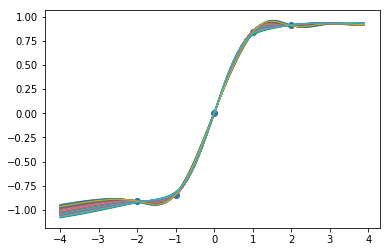

Function samples after 3000 steps:


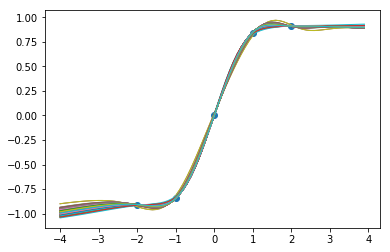

Function samples after 6000 steps:


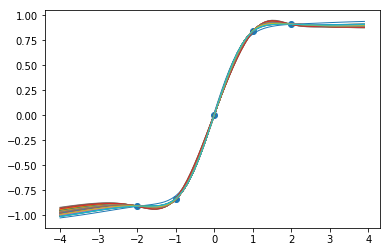

Function samples after 9000 steps:


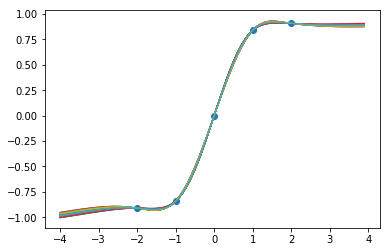

In [19]:
train(9001)

# Run experiments to see how the increase in number of context point affect the learning experience.